## 日本語版
※ ここではGoogle Colaraboratoryでの実行を想定しています。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/repos/deep-learning-with-pytorch-ja/p1ch7/

/content/drive/MyDrive/repos/deep-learning-with-pytorch-ja/p1ch7


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [4]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.get_device_name()

'Tesla K80'

In [8]:
torch.cuda.get_device_capability()

(3, 7)

In [13]:
tensor_sample = torch.Tensor([1, 2])
tensor_sample

tensor([1., 2.])

In [14]:
tensor_sample.device

device(type='cpu')

In [16]:
tensor_sample.to('cuda').device

device(type='cuda', index=0)

## 前項の前処理

In [17]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [18]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [19]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

## airplane と bird のみを抽出してモデリング

In [20]:
# ラベルの再定義
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

# （今回の場合は）
# __len__と__getitem__があれば良いのでDatasetオブジェクトではなくリストで対応可能
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [21]:
# 単純にモデルを組んでみる
import torch.nn as nn

n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,  # 3 x 32 x 32
                512,   # 任意
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # 一つ前に出力層数
                n_out, # 2
            )
        )
# n_outには[0]と[1]それぞれに対するスコアがはいる

In [22]:
# softmax関数は各スコアのベクトルを確率に変換する機能を持つ
# exp()を用いるのはexp()が単調増加関数であり、正負に惑わされないためである
# 但し、これを「確率」とする妥当性については、必ずしも妥当とは言えない可能性がある。
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [23]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [24]:
softmax(x).sum()

tensor(1.)

In [25]:
# softmax関数はnnモジュールに用意されている
# 次元指定が必要
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [26]:
# softmaxを用いて確率を返すNNを再定義
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


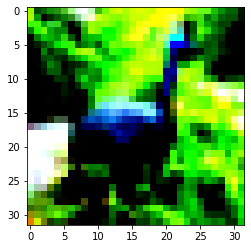

In [27]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [28]:
# 1枚入りのバッチを作成
img_batch = img.view(-1).unsqueeze(0) # 1次元化と次元の挿入
img_batch.shape

torch.Size([1, 3072])

In [29]:
# 未学習モデルで順伝播してみる
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)

In [30]:
# torch.max(tensor, dim)で値とargmaxを取得。予測結果を得る
_, index = torch.max(out, dim=1)

index

tensor([1])

In [31]:
# デモンストレーション用Output。バッチサイズ４だとする
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

# 正解ラベルを準備。
truth = torch.zeros((4,2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [32]:
# MSEの場合
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [33]:
(out - truth) ** 2

tensor([[0.1600, 0.1600],
        [0.0100, 0.0100],
        [0.0900, 0.0900],
        [0.0400, 0.0400]])

In [34]:
# 正解ラベルの確率のみを抽出
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [35]:
# MSE修正
def mse(out):
    return ((1 - out.gather(dim=1, index=class_index)) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.0750)

''

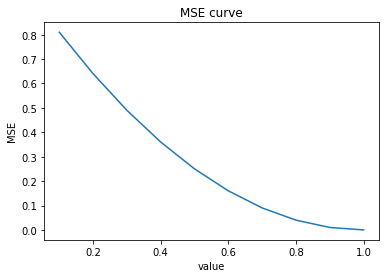

In [36]:
# MSEの見た目
samples = torch.Tensor([0.1 * (i+1) for i in range(10)])
plt.plot(samples, (1 - samples) ** 2)
plt.xlabel('value')
plt.ylabel('MSE')
plt.title('MSE curve')
;

In [37]:
# MSEではなく尤度損失関数を定義
# 各確度を掛け合わせる
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out)

tensor([0.3024])

In [38]:
# negative log likelihood
# 
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

''

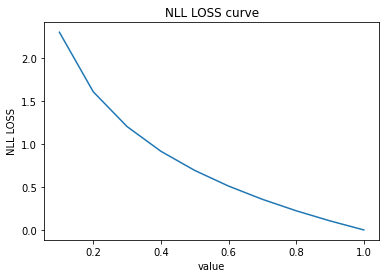

In [39]:
samples = torch.Tensor([0.1 * (i+1) for i in range(10)])
plt.plot(samples, -samples.log())
plt.xlabel('value')
plt.ylabel('NLL LOSS')
plt.title('NLL LOSS curve')
;

In [40]:
out.clone().detach()

tensor([[0.6000, 0.4000],
        [0.9000, 0.1000],
        [0.3000, 0.7000],
        [0.2000, 0.8000]])

In [41]:
# MSEの検証
# ズレの程度の違うoutputを準備して比べてみる。
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison
# ズレが大きいほどロスが大きい

tensor([0.0375, 0.0750, 0.1250, 0.2375])

In [42]:
# %diff
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [43]:
# NLLでもやってみる
nll_comparison = torch.tensor([neg_log_likelihood(o) 
                               for o in [out0, out, out2, out3]])
nll_comparison
# 同様にずれに応じてロスが大きくなる

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [44]:
# %diff
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

In [45]:
# nn.NLLLossは対数確率のテンソルを受け取る
# そのため、Networkの最後はsoftmaxではなくLogSoftmaxを使う

In [46]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [47]:
# 検証：log(softmaxx(x))とlog_softmax(x)の違い
# 結果：log_softmax(x)は0入力に対して無限に飛ばないようになっているっぽい
x = torch.tensor([[0.0, 108.0]])

In [48]:
x

tensor([[  0., 108.]])

In [49]:
softmax(x)

tensor([[0., 1.]])

In [50]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [51]:
log_softmax(x)

tensor([[-108.,    0.]])

In [52]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [53]:
# LogSoftmaxを採用したモデル
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [54]:
# NLLLossを採用: 出力と正解ラベルインデックスを引数に取る
loss = nn.NLLLoss()

In [55]:
# モデルを走らせてみる

img, label = cifar2[0]
print(label)

out = model(img.view(-1).unsqueeze(0))
print(out)
print(torch.exp(out))
print(loss(out, torch.tensor([label])))

1
tensor([[-0.9211, -0.5077]], grad_fn=<LogSoftmaxBackward>)
tensor([[0.3981, 0.6019]], grad_fn=<ExpBackward>)
tensor(0.5077, grad_fn=<NllLossBackward>)


In [61]:
%%time

# NLLLossで学習してみる
# 一枚ずつ学習する場合

import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

model.to('cuda')

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

losses = []
accs = []

for epoch in range(n_epochs):

    running_loss = 0.0
    running_acc = 0.0

    for img, label in cifar2:

        img_gpu = img.view(-1).unsqueeze(0).to('cuda')
        label_gpu = torch.tensor(label).unsqueeze(0).to('cuda')

        out = model(img_gpu)
        loss = loss_fn(out, label_gpu)


        optimizer.zero_grad()

        running_loss += loss.item() # .item()で値を取り出してrunning_lossに足す
        pred = torch.argmax(out, dim=1) # outputには各分類ラベルに対するスコアが入っているだけの状態なので、最高スコアを取り出す。そのラベルが予測値となる。
        running_acc += torch.mean(pred.eq(label).float()) # predとラベルが一致した率を計算
        loss.backward() # 誤差逆伝播
        optimizer.step() # 重みの更新

    running_loss /= len(cifar2) # 損失値の平均
    running_acc /= len(cifar2) # Accuracyの平均
    losses.append(running_loss) # このエポックでのロスをリストに追加
    accs.append(running_acc) # このエポックでのaccuracyをリストに追加
    print("epoch: {}, loss: {}, acc: {}".format(epoch, running_loss, running_acc))



epoch: 0, loss: 1.0512938993030403, acc: 0.6902999877929688
epoch: 1, loss: 1.378223772458892, acc: 0.6890999674797058
epoch: 2, loss: 1.3716015734166322, acc: 0.7015999555587769
epoch: 3, loss: 1.3549937291436651, acc: 0.710599958896637
epoch: 4, loss: 1.3589039073455065, acc: 0.7119999527931213
epoch: 5, loss: 1.2978271325659156, acc: 0.7263000011444092
epoch: 6, loss: 1.2996052466090593, acc: 0.7251999974250793
epoch: 7, loss: 1.30562867264698, acc: 0.7303999662399292
epoch: 8, loss: 1.2778166345128632, acc: 0.7317000031471252
epoch: 9, loss: 1.2254433247464498, acc: 0.7430999875068665
epoch: 10, loss: 1.2344567134346525, acc: 0.7416999936103821
epoch: 11, loss: 1.1978542913643357, acc: 0.7488999962806702
epoch: 12, loss: 1.2223383418244846, acc: 0.7465999722480774
epoch: 13, loss: 1.174067767058259, acc: 0.75409996509552
epoch: 14, loss: 1.2175537774424048, acc: 0.7479999661445618
epoch: 15, loss: 1.1724165712336894, acc: 0.7558000087738037
epoch: 16, loss: 1.1267510361384163, acc:

''

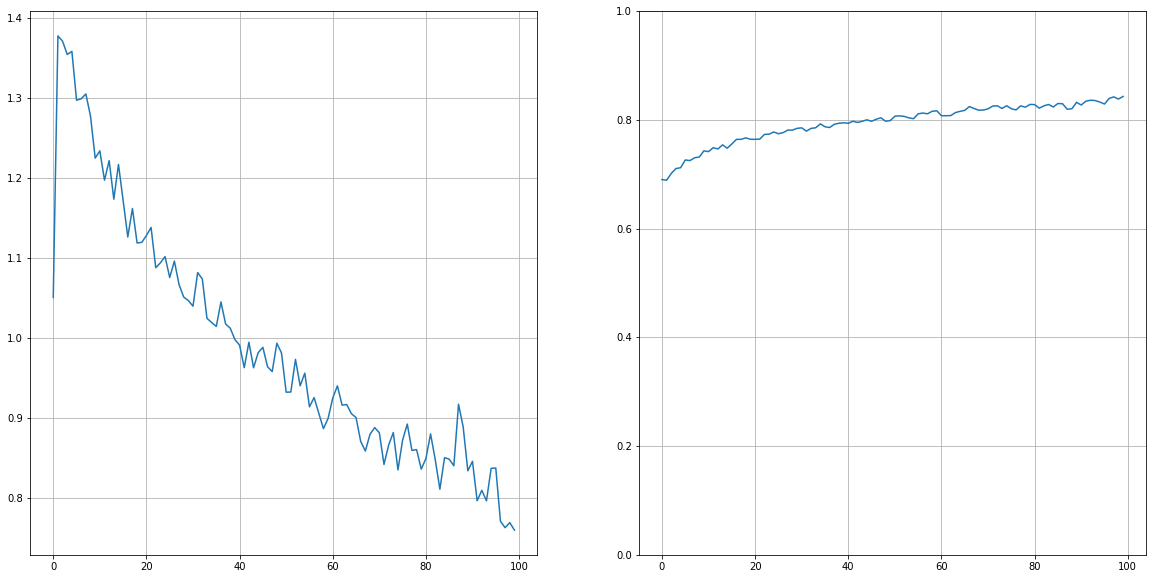

In [64]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
ax[0].plot(losses)
ax[0].grid()
ax[1].plot(accs)
ax[1].grid()
ax[1].set_ylim([0,1])
;

In [43]:
# DataLoaderを使う
# ミニバッチ作成
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

In [69]:
%%time
# DataLoaderでミニバッチ法を採用したモデル学習
# 高速且つ高精度
import torch
import torch.nn as nn
import torch.optim as optim

batch_size = 64
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

model.to('cuda')

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

losses = []
accs = []

for epoch in range(n_epochs):

    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_loader:

        imgs_gpu = imgs.view(imgs.shape[0], -1).to('cuda')
        labels_gpu = torch.tensor(labels).to('cuda')

        out = model(imgs_gpu)
        loss = loss_fn(out, labels_gpu)

        optimizer.zero_grad()

        running_loss += loss.item() # .item()で値を取り出してrunning_lossに足す
        pred = torch.argmax(out, dim=1) # outputには各分類ラベルに対するスコアが入っているだけの状態なので、最高スコアを取り出す。そのラベルが予測値となる。
        running_acc += torch.mean(pred.eq(labels_gpu).float()) # predとラベルが一致した率を計算
        loss.backward() # 誤差逆伝播
        optimizer.step() # 重みの更新

    running_loss /= len(train_loader) # 損失値の平均
    running_acc /= len(train_loader) # Accuracyの平均
    losses.append(running_loss) # このエポックでのロスをリストに追加
    accs.append(running_acc) # このエポックでのaccuracyをリストに追加
    print("epoch: {}, loss: {}, acc: {}".format(epoch, running_loss, running_acc))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0, loss: 0.503410399339761, acc: 0.7676154375076294
epoch: 1, loss: 0.461961876434885, acc: 0.7901074886322021
epoch: 2, loss: 0.44494474617538937, acc: 0.8013535141944885
epoch: 3, loss: 0.433253687468304, acc: 0.8083201050758362
epoch: 4, loss: 0.42040123472547836, acc: 0.8165804147720337
epoch: 5, loss: 0.41111283668666887, acc: 0.8235470056533813
epoch: 6, loss: 0.4007638636857841, acc: 0.8274283409118652
epoch: 7, loss: 0.39336308011203813, acc: 0.8316082954406738
epoch: 8, loss: 0.3823567596590443, acc: 0.8383758068084717
epoch: 9, loss: 0.37808330489951336, acc: 0.8377786874771118
epoch: 10, loss: 0.3663341765570792, acc: 0.8450437784194946
epoch: 11, loss: 0.35962712821687104, acc: 0.8487261533737183
epoch: 12, loss: 0.3500633413434788, acc: 0.8521099090576172
epoch: 13, loss: 0.34026900750056954, acc: 0.8600716590881348
epoch: 14, loss: 0.33200080986994845, acc: 0.8612659573554993
epoch: 15, loss: 0.3250789034898114, acc: 0.8677349090576172
epoch: 16, loss: 0.3198240821

''

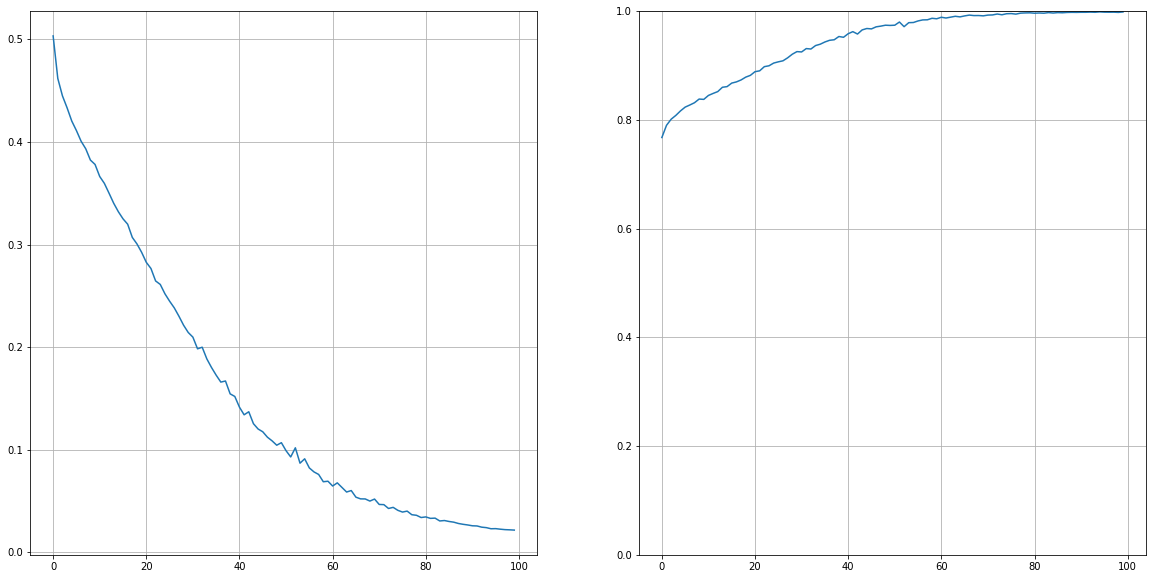

In [70]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
ax[0].plot(losses)
ax[0].grid()
ax[1].plot(accs)
ax[1].grid()
ax[1].set_ylim([0,1])
;

In [71]:
%%time

# 1層目の出力（2層目の入力）の数を 128 → 512
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

model.to('cuda')

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

losses = []
accs = []

for epoch in range(n_epochs):

    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_loader:

        imgs_gpu = imgs.view(imgs.shape[0], -1).to('cuda')
        labels_gpu = torch.tensor(labels).to('cuda')

        out = model(imgs_gpu)
        loss = loss_fn(out, labels_gpu)

        running_loss += loss.item() # .item()で値を取り出してrunning_lossに足す
        pred = torch.argmax(out, dim=1) # outputには各分類ラベルに対するスコアが入っているだけの状態なので、最高スコアを取り出す。そのラベルが予測値となる。
        running_acc += torch.mean(pred.eq(labels_gpu).float()) # predとラベルが一致した率を計算

        running_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    running_loss /= len(train_loader) # 損失値の平均
    running_acc /= len(train_loader) # Accuracyの平均
    losses.append(running_loss) # このエポックでのロスをリストに追加
    accs.append(running_acc) # このエポックでのaccuracyをリストに追加
    print("epoch: {}, loss: {}, acc: {}".format(epoch, running_loss, running_acc))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0, loss: 1.0204007625579834, acc: 0.7606489062309265
epoch: 1, loss: 0.9325363636016846, acc: 0.7901074886322021
epoch: 2, loss: 0.8994710445404053, acc: 0.7976711988449097
epoch: 3, loss: 0.8701286911964417, acc: 0.8080214858055115
epoch: 4, loss: 0.8515313863754272, acc: 0.8125995397567749
epoch: 5, loss: 0.8322487473487854, acc: 0.8156847357749939
epoch: 6, loss: 0.8135403990745544, acc: 0.8235470056533813
epoch: 7, loss: 0.7960615158081055, acc: 0.8254379034042358
epoch: 8, loss: 0.7794933319091797, acc: 0.831210196018219
epoch: 9, loss: 0.7650039196014404, acc: 0.8345939517021179
epoch: 10, loss: 0.7488049864768982, acc: 0.8389729261398315
epoch: 11, loss: 0.7329781651496887, acc: 0.8470342755317688
epoch: 12, loss: 0.7174133062362671, acc: 0.8464370965957642
epoch: 13, loss: 0.703234851360321, acc: 0.8480294942855835
epoch: 14, loss: 0.6850535273551941, acc: 0.8571855425834656
epoch: 15, loss: 0.6646571159362793, acc: 0.8620620965957642
epoch: 16, loss: 0.6570927500724792,

''

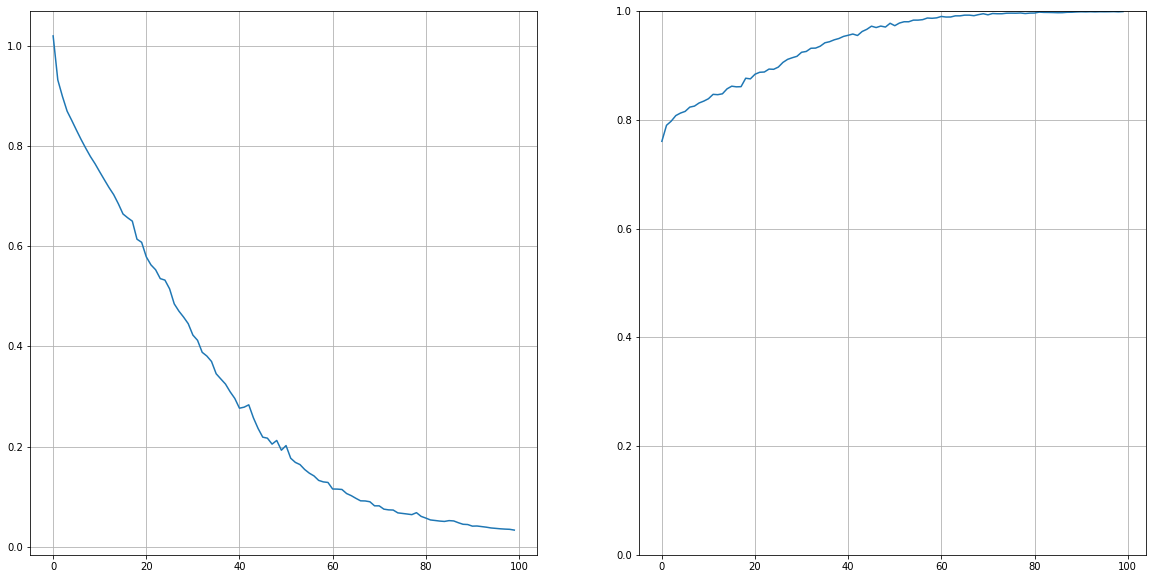

In [72]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
ax[0].plot(losses)
ax[0].grid()
ax[1].plot(accs)
ax[1].grid()
ax[1].set_ylim([0,1])
;

In [75]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to('cuda'))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels.to('cuda')).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.999000


In [76]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to('cuda'))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels.to('cuda')).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.821500


In [77]:
# 階層を一つ深くした
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

loss_fn = nn.NLLLoss()

In [78]:
# 線形層出力 + nn.CrossEntropyLoss()  ==  LogSoftmax()出力 + nn.NLLLoss()
# 書き方が簡単になるが、softmax値である予測確率を取り出せなくなるため注意
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

model.to('cuda')

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

losses = []
accs = []

for epoch in range(n_epochs):
    
    running_loss = 0.0
    running_acc = 0.0
    
    for imgs, labels in train_loader:

        imgs_gpu = imgs.view(imgs.shape[0], -1).to('cuda')
        labels_gpu = torch.tensor(labels).to('cuda')


        out = model(imgs_gpu)
        loss = loss_fn(out, labels_gpu)

        running_loss += loss.item() # .item()で値を取り出してrunning_lossに足す
        pred = torch.argmax(out, dim=1) # outputには各分類ラベルに対するスコアが入っているだけの状態なので、最高スコアを取り出す。そのラベルが予測値となる。
        running_acc += torch.mean(pred.eq(labels_gpu).float()) # predとラベルが一致した率を計算

        running_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    running_loss /= len(train_loader) # 損失値の平均
    running_acc /= len(train_loader) # Accuracyの平均
    losses.append(running_loss) # このエポックでのロスをリストに追加
    accs.append(running_acc) # このエポックでのaccuracyをリストに追加
    print("epoch: {}, loss: {}, acc: {}".format(epoch, running_loss, running_acc))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0, loss: 1.060393214225769, acc: 0.7524880766868591
epoch: 1, loss: 0.9649991989135742, acc: 0.7827428579330444
epoch: 2, loss: 0.9316498637199402, acc: 0.7899084687232971
epoch: 3, loss: 0.9086350202560425, acc: 0.7979697585105896
epoch: 4, loss: 0.8852522969245911, acc: 0.8049362897872925
epoch: 5, loss: 0.868069052696228, acc: 0.8114052414894104
epoch: 6, loss: 0.8489633798599243, acc: 0.8148885369300842
epoch: 7, loss: 0.8373306393623352, acc: 0.8169785141944885
epoch: 8, loss: 0.8192648887634277, acc: 0.8221536874771118
epoch: 9, loss: 0.8000763654708862, acc: 0.8301154375076294
epoch: 10, loss: 0.7884493470191956, acc: 0.8272293210029602
epoch: 11, loss: 0.7784499526023865, acc: 0.8294187784194946
epoch: 12, loss: 0.7654112577438354, acc: 0.8333997130393982
epoch: 13, loss: 0.7526055574417114, acc: 0.8360868096351624
epoch: 14, loss: 0.7272356748580933, acc: 0.8436505198478699
epoch: 15, loss: 0.7159728407859802, acc: 0.8478304147720337
epoch: 16, loss: 0.7085907459259033,

''

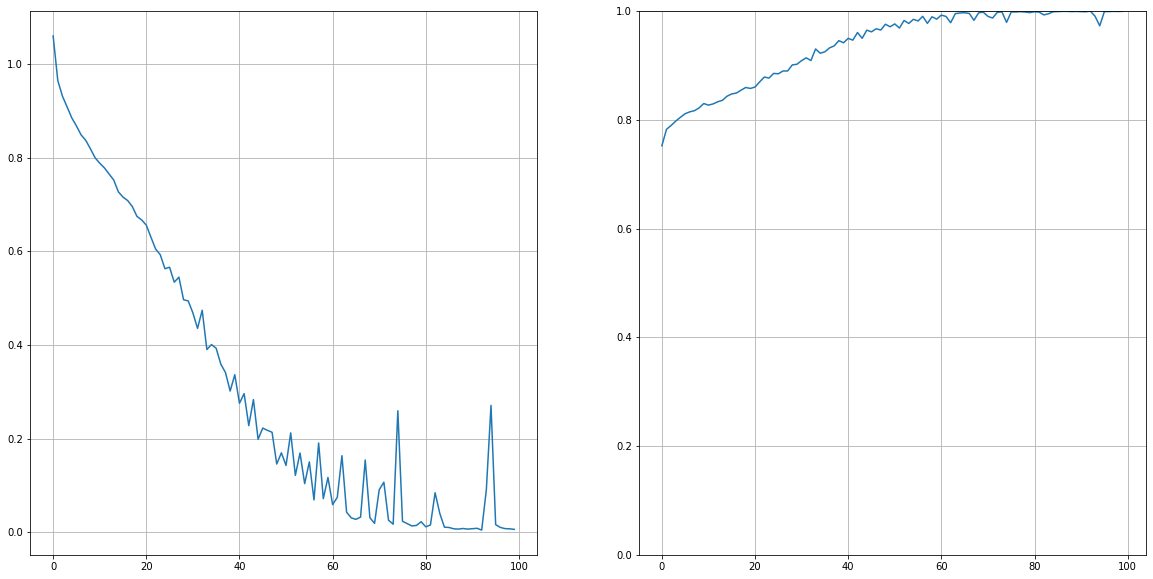

In [82]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
ax[0].plot(losses)
ax[0].grid()
ax[1].plot(accs)
ax[1].grid()
ax[1].set_ylim([0,1])
;

In [84]:
# 訓練誤差は殆ど無し
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to('cuda'))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels.to('cuda')).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.999900


In [85]:
# 検証誤差は結構ある
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to('cuda'))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels.to('cuda')).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.803000


In [87]:
# parameters()はlen()不可
len(model.parameters())

TypeError: ignored

In [88]:
# 直近モデルだと370万パラメータ
sum([p.numel() for p in model.parameters()])

3737474

In [89]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

In [91]:
# 最初のモデルだと150万パラメータ
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

sum([p.numel() for p in first_model.parameters()])

1574402

In [92]:
# 最初の層がほとんどのパラメータ数を占める
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

1573376

In [93]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])

3146752

In [94]:
# 1024 x 1024の画像などはGPUメモリ的にキツくなる
sum([p.numel() for p in nn.Linear(1024 * 1024, 1024).parameters()])

1073742848

In [ ]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [ ]:
conv = nn.Conv2d(3, 16, kernel_size=3)

In [ ]:
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [ ]:
conv.bias.shape

torch.Size([16])

In [ ]:
img, _ = cifar2[0]

output = conv(img.unsqueeze(0))

In [ ]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


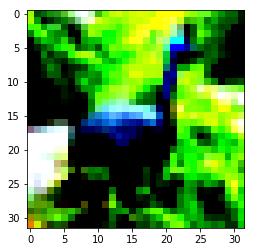

In [ ]:
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.show()

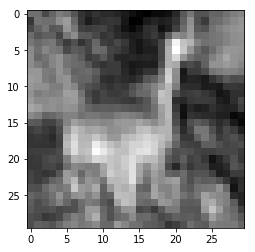

In [ ]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [ ]:
output.shape

torch.Size([1, 16, 30, 30])

In [ ]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

In [ ]:
output = conv(img.unsqueeze(0))

output.shape

torch.Size([1, 1, 32, 32])

In [ ]:
with torch.no_grad():
    conv.bias.zero_()

In [ ]:
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

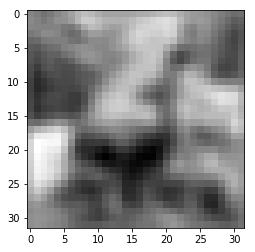

In [ ]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [ ]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

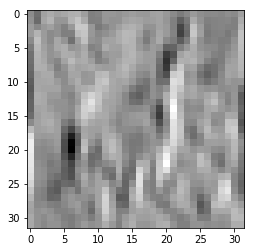

In [ ]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [ ]:
pool = nn.MaxPool2d(2)

In [ ]:
output = pool(img.unsqueeze(0))

output.shape

torch.Size([1, 3, 16, 16])

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            ...)

TypeError: ellipsis is not a Module subclass

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # WARNING: something missing here
            nn.Linear(512, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [ ]:
sum([p.numel() for p in model.parameters()])

In [ ]:
model(img.unsqueeze(0))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Net()

sum([p.numel() for p in model.parameters()])

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Net()
model(img.unsqueeze(0))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()
sum([p.numel() for p in model.parameters()])

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Linear(8*8*8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

model(img.unsqueeze(0))